In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [16]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [19]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(autoload_with=engine)

# reflect the tables
Base.prepare(engine, reflect=True)

C:\Users\Muskan\AppData\Local\Temp\ipykernel_42080\2829631002.py:6: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [20]:
# View all of the classes that automap found
print(Base.classes.keys())


['station', 'measurement']


In [22]:
# Save references to each table

station=Base.classes.station
measurements=Base.classes.measurement

In [21]:
# Create our session (link) from Python to the DB

session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [23]:
# Find the most recent date in the data set.
session.query(measurements.date).order_by(measurements.date.desc()).first()

('2017-08-23',)

<Figure size 1200x600 with 0 Axes>

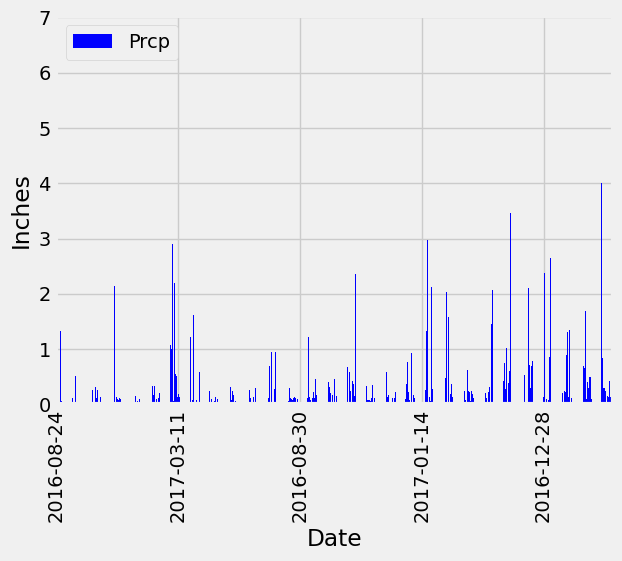

In [55]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
year_ago=dt.date(2017,8,23) - dt.timedelta(days=365)
year_ago

# Perform a query to retrieve the data and precipitation scores
# Assuming `year_ago` is already defined and `measurements` refers to the correct table reference
data = session.query(measurements).filter(measurements.date > year_ago).filter(measurements.prcp ).all()


# Save the query results as a Pandas DataFrame. Explicitly set the column names
# Convert the query results to a DataFrame, specifying the column names
data_rows = [{"Date": d.date, "Prcp": d.prcp} for d in data]


# Display the DataFrame
data_df=pd.DataFrame(data_rows)
data_df.head()

# Sort the dataframe by date
plot_data=data_df.set_index("Date")

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(12, 6))

plot_data.plot(kind='bar', color="blue", label="Precipitation")

plt.xlabel("Date")
plt.ylabel("Inches")


plt.legend()

# Limit the number of date ticks shown
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(5))

plt.show()

In [59]:
# Use Pandas to calculate the summary statistics for the precipitation data
plot_data.describe()


,Prcp
count,1142.000000
mean,0.311357
std,0.576134
min,0.010000
25%,0.030000
50%,0.100000
75%,0.310000
max,6.700000


# Exploratory Station Analysis

In [60]:
# Design a query to calculate the total number of stations in the dataset

total_count=session.query(station).distinct().count()
print(total_count)

9


In [68]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
most_active_stations = (
    session.query(measurements.station, func.count(measurements.station).label('count'))
    .group_by(measurements.station)
    .order_by(func.count(measurements.station).desc())
    .all()
)

# List the stations and their counts in descending order.
# Display the results
most_active_stations




[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [75]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

most_active_station_id = 'USC00519281'

# Query to calculate the lowest, highest, and average temperatures
temperature_data = session.query(
    func.min(measurements.tobs).label('min_temp'),
    func.max(measurements.tobs).label('max_temp'),
    func.avg(measurements.tobs).label('avg_temp')
).filter(measurements.station == most_active_station_id).all()

# Display the results
min_temp, max_temp, avg_temp = temperature_data[0]
print(temperature_data)

[(54.0, 85.0, 71.66378066378067)]


<Figure size 1000x600 with 0 Axes>

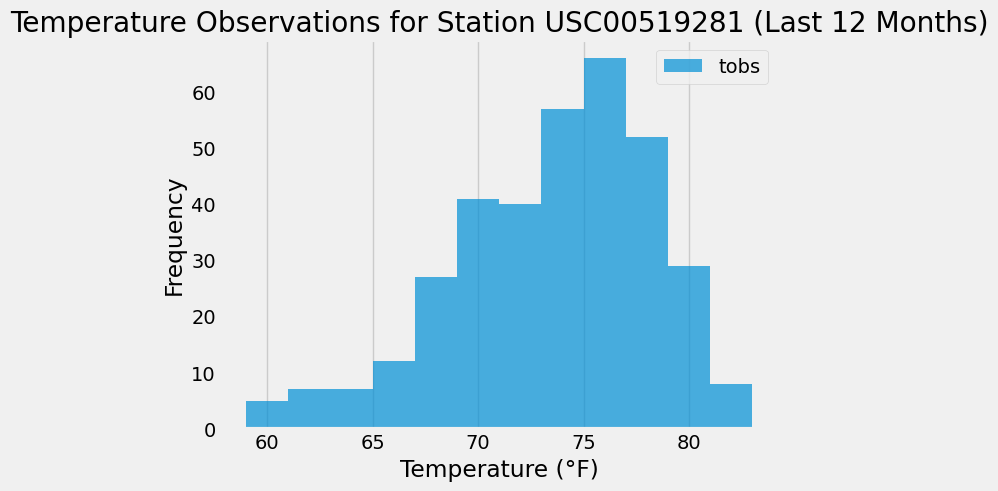

In [80]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Most active station ID
most_active_station_id = 'USC00519281'

# Calculate the date one year ago from the most recent date in the dataset
most_recent_date=session.query(measurements.date).order_by(measurements.date.desc()).first()[0]
last_year_date = dt.datetime.strptime(most_recent_date, '%Y-%m-%d') - dt.timedelta(days=365)

# Query to get the last 12 months of TOBS data for the most active station
tobs_data = session.query(measurements.tobs).filter(
    measurements.station == most_active_station_id,
    measurements.date >= last_year_date
).all()

# Convert the results to a Pandas DataFrame
tobs_df = pd.DataFrame(tobs_data, columns=['tobs'])

# Plot the histogram
plt.figure(figsize=(10, 6))
tobs_df.plot(kind='hist', bins=12, alpha=0.7)
plt.title(f'Temperature Observations for Station {most_active_station_id} (Last 12 Months)')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()






# Close Session

In [16]:
# Close Session
session.close()